# P02 - Feature Engineering - Churn

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(style="whitegrid")
sns.set_context("notebook")

In [2]:
from IPython.display import Markdown, display

OUT = "output"
import os
os.makedirs(OUT, exist_ok=True)

In [3]:
display_fraction = lambda n,d: (n/d*100, n, d)

In [4]:
df_lat_long = pd.read_csv("src/latlong.csv")
df_lat_long.head()

,state,latitude,longitude,name
0,AK,63.588753,-154.493062,Alaska
1,AL,32.318231,-86.902298,Alabama
2,AR,35.201050,-91.831833,Arkansas
3,AZ,34.048928,-111.093731,Arizona
4,CA,36.778261,-119.417932,California


## Load and Prepare the Data 

I have made a slight change of naming convention which will simply code below - and also avoid mistakes in lab sessions when I rerun cells out of order to demo parts of the code.   Rather than using __df__ to store the full dataset I will use __df_all__, and use __df__ as an alias for various dataset as needed - see [Feature Engineering](#Feature_Engineering). So will try to follow naming convention:

 * __df__ alias for various datasets (trwated link a tmp variable, more later). 
 * __df_all__ full dataset after loading and prepped (columns renamed, value recoded).
 * __df_model__ dataset with target and a subset of the original attributes that may appear in model or be used to construct other attributes.
 * __df_train__ dataset 
 * __df_test__ dataset 

 


In [5]:
df_all = pd.read_csv("src/churn.csv")

message = (" * Data set consists of %d cases (rows) with %s attributes (cols) and a single target."  
% (df_all.shape[0], df_all.shape[1]-1))
Markdown(message)

 * Data set consists of 3333 cases (rows) with 20 attributes (cols) and a single target.

In [6]:
df_all.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [7]:
Markdown("States latlong = (%d), churn states = (%d)" % (len(df_lat_long.state), len(df_all.State)))

States latlong = (52), churn states = (3333)

In [8]:
df = df_all.merge(df_lat_long, left_on='State', right_on='state', suffixes=(False, False))

Get list of columns, some name contain spaces, or other unsuitable characters, which need to be removed.

In [9]:
df_all = df.drop(['state', 'name'], axis=1)

In [10]:
df_all.shape

(3333, 23)

In [11]:
names = df_all.columns.tolist()
print("Original columns names:\n", names)

Original columns names:
 ['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?', 'latitude', 'longitude']


In [12]:
CORRECTIONS = {" ":"_", "'":"", "?":"", "CustServ":"Cust_Serv"}

def fixName(s):
    for a,b in CORRECTIONS.items():
        s = s.replace(a,b)
    return s

mapping = {c:fixName(c) for c in names}

In [13]:
df_all.rename(columns=mapping, inplace=True)

In [14]:
df_all.head()

,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,Cust_Serv_Calls,Churn,latitude,longitude
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,False.,39.011902,-98.484246
1,KS,70,408,411-4582,no,no,0,232.1,122,39.46,...,201.2,112,9.05,0.0,0,0.00,3,False.,39.011902,-98.484246
2,KS,92,408,386-4170,yes,no,0,62.6,111,10.64,...,221.7,80,9.98,10.4,2,2.81,1,True.,39.011902,-98.484246
3,KS,137,408,352-8202,no,no,0,205.9,88,35.00,...,289.9,84,13.05,14.5,4,3.92,2,False.,39.011902,-98.484246
4,KS,132,415,369-3214,no,no,0,83.4,110,14.18,...,146.7,114,6.60,7.6,5,2.05,1,False.,39.011902,-98.484246


Replace the binary target and the two binary features with numerical values.

In [15]:
df_all.Intl_Plan = df_all.Intl_Plan.map( {"yes":1, "no":0} )
df_all.VMail_Plan = df_all.VMail_Plan.apply( lambda x: int(x=='yes') )
df_all.Churn = df_all.Churn.apply( lambda x: int(x=="True.") )

In [16]:
df_all.head()

,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,Cust_Serv_Calls,Churn,latitude,longitude
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,0,39.011902,-98.484246
1,KS,70,408,411-4582,0,0,0,232.1,122,39.46,...,201.2,112,9.05,0.0,0,0.00,3,0,39.011902,-98.484246
2,KS,92,408,386-4170,1,0,0,62.6,111,10.64,...,221.7,80,9.98,10.4,2,2.81,1,1,39.011902,-98.484246
3,KS,137,408,352-8202,0,0,0,205.9,88,35.00,...,289.9,84,13.05,14.5,4,3.92,2,0,39.011902,-98.484246
4,KS,132,415,369-3214,0,0,0,83.4,110,14.18,...,146.7,114,6.60,7.6,5,2.05,1,0,39.011902,-98.484246


In [17]:
# save data for comparision with R model 
if False:
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=666)
    open ("data/churn_train.csv", "wt").write(df_train.to_csv())
    open ("data/churn_test.csv", "wt").write(df_test.to_csv())

## Pre-Processing Data

In [18]:
target = "Churn"
attributes = df_all.columns.tolist()
attributes.remove(target) 
attributes = [a for a in attributes if a not in ["State", "Phone", "Area_Code"]]
attributes = [a for a in attributes if a.split("_")[-1] != "Charge"]

df_model = df_all.loc[:, attributes + [target]]

In [19]:
attributes_initial = df_model.columns.tolist()
attributes_initial.remove(target)

### Side Note - Down-Sampling 

When a dataset is imbalanced, one can generate a balanced dataset by taking a sample of the larger set.

In [20]:
df_balanced_down_sampling = pd.concat ([
    df_all[df_all.Churn==0].sample(n=sum(df_all.Churn==1), random_state=42),
    df_all[df_all.Churn==1]])

### Train-Test Split

In [21]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=42)

## Feature_Engineering 

Features engineering and selection decision is carried out on __df_train__ ONLY, but resulting operations should be applied to both __df_train__ and __df_test__. The simplest way to do this (without repeating code) is to apply operations to __df_model__ and repeat the train/test split USING THE SAME SEED.

### New Feature - Cranky Triskaidekaphobias

Would a feature indicating customers who complain and avoid the number 13 be useful in predicting Churn?

In [22]:
my_query = df_model.query('Cust_Serv_Calls>0 & Day_Calls!=13 & Eve_Calls!=13 & Night_Calls!=13 & Intl_Calls!=13')
my_query.head()

,Account_Length,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Eve_Mins,Eve_Calls,Night_Mins,Night_Calls,Intl_Mins,Intl_Calls,Cust_Serv_Calls,latitude,longitude,Churn
0,128,0,1,25,265.1,110,197.4,99,244.7,91,10.0,3,1,39.011902,-98.484246,0
1,70,0,0,0,232.1,122,292.3,112,201.2,112,0.0,0,3,39.011902,-98.484246,0
2,92,1,0,0,62.6,111,180.6,126,221.7,80,10.4,2,1,39.011902,-98.484246,1
3,137,0,0,0,205.9,88,209.3,86,289.9,84,14.5,4,2,39.011902,-98.484246,0
4,132,0,0,0,83.4,110,232.2,137,146.7,114,7.6,5,1,39.011902,-98.484246,0


In [23]:
df_model["Cranky_Triskaidekaphobias"] = df_model.apply (lambda row: (row.Cust_Serv_Calls>0 
            and row.Day_Calls!=13 and row.Eve_Calls!=13 
            and row.Night_Calls!=13 and row.Intl_Calls!=13), axis=1)

### New Feature - ????


In [41]:
df_model.columns

Index(['Intl_Plan', 'Day_Mins', 'Eve_Mins', 'Intl_Calls', 'Cust_Serv_Calls',
       'Churn'],
      dtype='object')

In [38]:
avg_calls = (df_model.Day_Calls.mean() + df_model.Eve_Calls.mean() + df_model.Night_Calls.mean())
# avg_calls
#my_query a= df_model.query('(Day_Mins+Eve_Calls+Night_Calls) < %d' % (avg_calls))
#my_query.head()
# df_model["Test_Feature"] = 
# df_model["Test_Feature"].head()
df_model.columns
# df_model["SomeBullShit"] = df_model.Day_Calls + df_model.Eve_Calls + df_Model.Night_Calls < avg_call

AttributeError: 'DataFrame' object has no attribute 'Day_Calls'

### New Feature - ????


### New Feature - ????


### New Feature - ????


### New Feature - ????


### New Feature - ????


### New Feature - ????


## Model Training

In [26]:
print (df_model.columns.values)

['Account_Length' 'Intl_Plan' 'VMail_Plan' 'VMail_Message' 'Day_Mins'
 'Day_Calls' 'Eve_Mins' 'Eve_Calls' 'Night_Mins' 'Night_Calls' 'Intl_Mins'
 'Intl_Calls' 'Cust_Serv_Calls' 'latitude' 'longitude' 'Churn'
 'Cranky_Triskaidekaphobias']


### Train-Test Split

REPEAT train/test split from above so that both data subsets have the modified feature set.

In [27]:
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=42)
attributes = df_model.columns.tolist()
attributes.remove(target)

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,attributes].astype(float))
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,attributes].astype(float))
y_test = df_test.Churn.values

### Evaluation

We spoke about the AUC metric last week. This week we will focus on recall - it is easier and probably more relevant in this case and we want to focus on identifying as many Churn customers as possible.

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, roc_auc_score

models = []

### Training - First Iteration

Just fix a few of our standard classifiers, using default/semi-sane parameters.

#### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
models.append( {"name":"LogisticRegression", "ref": LogisticRegression(solver="lbfgs")} )

#### Support Vector Machines

In [31]:
from sklearn.svm import SVC
models.append( {"name":"SVC", "ref":SVC(gamma="scale")} )

#### Decision Trees

In [32]:
from sklearn.tree import DecisionTreeClassifier
models.append( {"name":"DT (prunned=4)", "ref":DecisionTreeClassifier(criterion='entropy', max_depth=4)} )

In [33]:
for model in models:
    
    crossval_scores = cross_val_score(model["ref"], X_train, y_train, scoring='recall', cv=5)
    print ("\nModel %s" % model["name"])
    print ("\tCV scores %s" % crossval_scores)
    print ("\tmean=%.3f std=%.3f" % (crossval_scores.mean(), crossval_scores.std()))


Model LogisticRegression
	CV scores [0.17808219 0.15068493 0.18055556 0.26388889 0.20833333]
	mean=0.196 std=0.038

Model SVC
	CV scores [0.45205479 0.32876712 0.375      0.40277778 0.43055556]
	mean=0.398 std=0.043

Model DT (prunned=4)
	CV scores [0.57534247 0.52054795 0.52777778 0.375      0.47222222]
	mean=0.494 std=0.068


### Feature Selection

Optimal number of features : 5


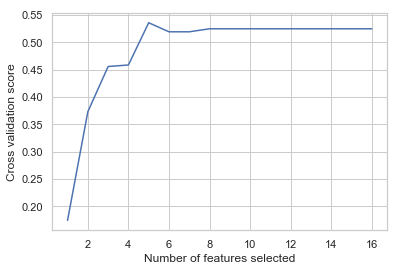

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

model = models[2]["ref"]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="recall")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [35]:
# list of features selected
attributes_selected = np.array(attributes)[rfecv.support_].tolist()
attributes_selected

['Intl_Plan', 'Day_Mins', 'Eve_Mins', 'Intl_Calls', 'Cust_Serv_Calls']

### Training - After Feature Selection

In [36]:
df_model = df_model.loc[:, attributes_selected + [target]]
display(df_model.head())

# train-test split
df_train, df_test = train_test_split(df_model, stratify=df_model[target], test_size=.25, random_state=42)
attributes = df_model.columns.tolist()
attributes.remove(target)

# normalise 
X_train = scaler.fit_transform(df_train.loc[:,attributes].astype(float))
y_train = df_train.Churn.values
X_test = scaler.transform(df_test.loc[:,attributes].astype(float))
y_test = df_test.Churn.values

for model in models:
    
    crossval_scores = cross_val_score(model["ref"], X_train, y_train, scoring='recall', cv=5)
    print ("\nModel %s" % model["name"])
    print ("\tCV scores %s" % crossval_scores)
    print ("\tmean=%.3f std=%.3f" % (crossval_scores.mean(), crossval_scores.std()))

,Intl_Plan,Day_Mins,Eve_Mins,Intl_Calls,Cust_Serv_Calls,Churn
0,0,265.1,197.4,3,1,0
1,0,232.1,292.3,0,3,0
2,1,62.6,180.6,2,1,1
3,0,205.9,209.3,4,2,0
4,0,83.4,232.2,5,1,0



Model LogisticRegression
	CV scores [0.15068493 0.09589041 0.13888889 0.22222222 0.125     ]
	mean=0.147 std=0.042

Model SVC
	CV scores [0.36986301 0.4109589  0.43055556 0.375      0.375     ]
	mean=0.392 std=0.024

Model DT (prunned=4)
	CV scores [0.5890411  0.47945205 0.48611111 0.47222222 0.48611111]
	mean=0.503 std=0.044
